![title](hotelbed.jpg)

## Table of contents
1. [Initialization](#initialization)
2. [Basic Data Exploration,Feature Creation and Transformation](#bda)
3. [Feature Analysis](#fa)
    1. [ContractID](#contID)
    2. [Star Rating](#star)
    3. [Room Type](#room)
    4. [Arrival Month](#month)
    5. [Category](#cat)
    6. [Meal Basis](#meal)
    7. [Contract Type](#contract)
    8. [Other Date Variables](#date)
    9. [Time Variables](#time)
    10. [City](#city)
    11. [Hotel Key](#hotel)
4. [Data Set Transformation](#transformation)
5. [Outlier/Anomaly Detection](#outlierDetection)    
    1. [Statistical and Visual Approach](#stat)
    2. [Clustering and Regression Approach](#cluster)
5. [Anomaly Labeling and Submission](#submit)

In [2]:
# importing primary libraries
import numpy as np
import pandas as pd
from collections import Counter
import datetime as dt
import workdays
import glob
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)


%matplotlib inline

In [1]:
# Loading cleaned df
df = pd.read_csv('TransformedData.csv', index_col= 0)
df.head()

NameError: name 'df' is not defined

### OUTLIER/ANOMALY DETECTION <a name="outlierDetection"></a>

In [1]:
df.head()

NameError: name 'df' is not defined

In [106]:
df.columns

Index(['TripNoOfDays', 'TripWorkingDays', 'TripWeekends', 'BookingLeadTime',
       'PricePerNight', 'ContractIdMean', 'priceDifbyContractMean',
       'HotelStarRating', 'MedianPriceByRoomType', 'monthRating',
       'categoryRoomPriceRank', 'mealBasisDeviation', 'mealBasisRank',
       'contract_NOR', 'contract_OPQ', 'contract_NRF', 'contract_UND',
       'contract_SPE', 'contractDeviation', 'DurationDeviation',
       'durationType', 'WeekendIncluded', 'cityRank', 'cityDeviation',
       'CityKurtosis'],
      dtype='object')

As mentioned earlier we will proceed with a 2 fold process here. First we will create outlier score based on the features that explain the deviation of the price from the expected mean or median. This will be used to detect price points which have a high probability of being anomalouos. The actual price recorded will also be taken into consideration while making this criteria.
The second approach will use clustering and regression to group similar bookings together and define outliers based on regression scores and residuals for each of fthe clusters

In [107]:
# Scaling dataset
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(np_scaled, index=df.index, columns=df.columns)

In [108]:
df_scaled.head()

,TripNoOfDays,TripWorkingDays,TripWeekends,BookingLeadTime,PricePerNight,ContractIdMean,priceDifbyContractMean,HotelStarRating,MedianPriceByRoomType,monthRating,categoryRoomPriceRank,mealBasisDeviation,mealBasisRank,contract_NOR,contract_OPQ,contract_NRF,contract_UND,contract_SPE,contractDeviation,DurationDeviation,durationType,WeekendIncluded,cityRank,cityDeviation,CityKurtosis
row_id,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.575838,0.413620,0.690505,-0.317700,1.063062,0.350324,1.104157,0.473183,1.049980,0.0,1.708964,-0.256506,-0.649972,-1.117465,2.216884,-0.460596,-0.386265,-0.034652,-0.388313,-0.304524,-0.418327,0.654486,-0.087514,-0.045363,0.607779
1,0.210293,-0.063525,0.690505,-0.029443,-0.417529,-0.659671,0.020082,-3.017766,-1.111124,0.0,-0.277772,-0.256506,-0.055805,0.894882,-0.451084,-0.460596,-0.386265,-0.034652,-0.388313,-0.304524,-0.418327,0.654486,-0.087514,2.139355,-1.627399
2,0.575838,0.413620,0.690505,-0.850975,1.529439,2.926425,-0.520175,1.636832,0.396359,0.0,0.218912,-0.256506,-0.649972,0.894882,-0.451084,-0.460596,-0.386265,-0.034652,-0.388313,-0.304524,-0.418327,0.654486,2.311026,-0.045363,-1.119404
3,-0.155253,-0.540669,0.690505,-0.634782,-0.311005,0.552051,-0.893011,-0.690467,-0.536844,0.0,-0.277772,-0.256506,-0.055805,-1.117465,-0.451084,-0.460596,2.588894,-0.034652,2.575243,-0.304524,-0.418327,0.654486,-0.887027,-0.773602,1.217373
4,-0.155253,0.413620,-1.240497,-0.591544,-0.475714,-0.898199,0.150693,-0.690467,-1.111124,0.0,-0.277772,-0.256506,-0.649972,0.894882,-0.451084,-0.460596,-0.386265,-0.034652,-0.388313,-0.304524,-0.418327,-1.527917,-0.087514,-0.045363,0.506180


#### Statistical and Visualization Approach <a name="stat"></a>

In [109]:
# Take the deviation columns and create an outlier score
df_scaled['outlierScore'] = ((df_scaled.priceDifbyContractMean*100) *
                            ((df_scaled.mealBasisDeviation + df_scaled.contractDeviation + 
                            df_scaled.DurationDeviation + df_scaled.cityDeviation + df_scaled.CityKurtosis) * 10 ))
df_scaled['outlierScore'] = preprocessing.scale(df_scaled['outlierScore'])

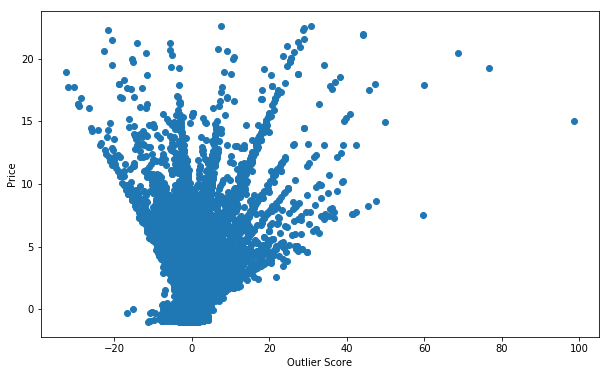

In [110]:
# Scatter Plot of the outlier score over price
plt.figure(figsize=(10,6))
plt.scatter(df_scaled.outlierScore,df_scaled.PricePerNight)
plt.ylabel('Price')
plt.xlabel('Outlier Score');

The dispersion of the data points shows clearly that extremely high outlier scores on either side can be treated as anomalies. Thus high outlier score and high prices on the extreme ends of the distribution (including the negetive side of outlier score) can be tagged as anomalies.

In [111]:
## Returning the outliers from both sides of the distribution

# On the positive side
print(df_scaled.loc[(df_scaled.outlierScore > 30), 'PricePerNight'].size) # 10
print(df_scaled.loc[((df_scaled.outlierScore > 20) & (df_scaled.outlierScore < 30)) & (df_scaled.PricePerNight > 12), 'PricePerNight'].size) # 10

# On the negative side
print(df_scaled.loc[(df_scaled.outlierScore < -15) & (df_scaled.PricePerNight < 5), 'PricePerNight'].size)
print(df_scaled.loc[(df_scaled.outlierScore < -15) & (df_scaled.PricePerNight > 15), 'PricePerNight'].size)

58
41
2
22


The boundary conditions are set based on the distribution observed in the scatter plot above and also keeping tight rules to allow for lower probability of False positives

In [112]:
# New Data Frame containing the previously spotted anomalies
df_anomaly3 = pd.DataFrame( df_scaled.loc[ 
                   (df_scaled.outlierScore > 30)
                 | (((df_scaled.outlierScore > 20) & (df_scaled.outlierScore < 30)) & (df_scaled.PricePerNight > 12))
                 | ((df_scaled.outlierScore < -15) & (df_scaled.PricePerNight < 5))
                 | ((df_scaled.outlierScore < -15) & (df_scaled.PricePerNight > 15))
                  , 'PricePerNight'])   

In [113]:
df_anomaly3.shape

(123, 1)

In [114]:
df_scaled = df_scaled.loc[df_scaled.index.isin(df_anomaly3.index) == False , :]

In [115]:
df_scaled.columns

Index(['TripNoOfDays', 'TripWorkingDays', 'TripWeekends', 'BookingLeadTime',
       'PricePerNight', 'ContractIdMean', 'priceDifbyContractMean',
       'HotelStarRating', 'MedianPriceByRoomType', 'monthRating',
       'categoryRoomPriceRank', 'mealBasisDeviation', 'mealBasisRank',
       'contract_NOR', 'contract_OPQ', 'contract_NRF', 'contract_UND',
       'contract_SPE', 'contractDeviation', 'DurationDeviation',
       'durationType', 'WeekendIncluded', 'cityRank', 'cityDeviation',
       'CityKurtosis', 'outlierScore'],
      dtype='object')

In [116]:
# Removing the variables that we will not use anymore
df_scaled = df_scaled.drop(['priceDifbyContractMean' , 'mealBasisDeviation', 
                            'contractDeviation', 'DurationDeviation', 'cityDeviation', 
                            'CityKurtosis', 'outlierScore'], axis = 1)

#### Cluster and Regression Approach <a name="cluster"></a>

In [117]:
data = df_scaled

data.head()

,TripNoOfDays,TripWorkingDays,TripWeekends,BookingLeadTime,PricePerNight,ContractIdMean,HotelStarRating,MedianPriceByRoomType,monthRating,categoryRoomPriceRank,mealBasisRank,contract_NOR,contract_OPQ,contract_NRF,contract_UND,contract_SPE,durationType,WeekendIncluded,cityRank
row_id,,,,,,,,,,,,,,,,,,,
0,0.575838,0.413620,0.690505,-0.317700,1.063062,0.350324,0.473183,1.049980,0.0,1.708964,-0.649972,-1.117465,2.216884,-0.460596,-0.386265,-0.034652,-0.418327,0.654486,-0.087514
1,0.210293,-0.063525,0.690505,-0.029443,-0.417529,-0.659671,-3.017766,-1.111124,0.0,-0.277772,-0.055805,0.894882,-0.451084,-0.460596,-0.386265,-0.034652,-0.418327,0.654486,-0.087514
2,0.575838,0.413620,0.690505,-0.850975,1.529439,2.926425,1.636832,0.396359,0.0,0.218912,-0.649972,0.894882,-0.451084,-0.460596,-0.386265,-0.034652,-0.418327,0.654486,2.311026
3,-0.155253,-0.540669,0.690505,-0.634782,-0.311005,0.552051,-0.690467,-0.536844,0.0,-0.277772,-0.055805,-1.117465,-0.451084,-0.460596,2.588894,-0.034652,-0.418327,0.654486,-0.887027
4,-0.155253,0.413620,-1.240497,-0.591544,-0.475714,-0.898199,-0.690467,-1.111124,0.0,-0.277772,-0.649972,0.894882,-0.451084,-0.460596,-0.386265,-0.034652,-0.418327,-1.527917,-0.087514


In [118]:
PricePerNight = data.PricePerNight

In [119]:
data = data.drop(['PricePerNight'], axis =1 )

In [120]:
# Take useful features and standardize them
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled, index=data.index)

In [121]:
columNames = df_scaled.columns.drop(['PricePerNight'])
data.columns = columNames

In [122]:
print(data.shape)
data.head()

(890387, 18)


,TripNoOfDays,TripWorkingDays,TripWeekends,BookingLeadTime,ContractIdMean,HotelStarRating,MedianPriceByRoomType,monthRating,categoryRoomPriceRank,mealBasisRank,contract_NOR,contract_OPQ,contract_NRF,contract_UND,contract_SPE,durationType,WeekendIncluded,cityRank
row_id,,,,,,,,,,,,,,,,,,
0,0.577039,0.414300,0.690784,-0.317656,0.350566,0.473360,1.050173,0.0,1.711563,-0.649944,-1.117573,2.216770,-0.460626,-0.386133,-0.034654,-0.418282,0.654527,-0.087458
1,0.210898,-0.063366,0.690784,-0.029379,-0.659638,-3.017772,-1.111077,0.0,-0.277998,-0.055756,0.894796,-0.451107,-0.460626,-0.386133,-0.034654,-0.418282,0.654527,-0.087458
2,0.577039,0.414300,0.690784,-0.850969,2.927198,1.637071,0.396508,0.0,0.219392,-0.649944,0.894796,-0.451107,-0.460626,-0.386133,-0.034654,-0.418282,0.654527,2.311175
3,-0.155242,-0.541032,0.690784,-0.634761,0.552334,-0.690350,-0.536759,0.0,-0.277998,-0.055756,-1.117573,-0.451107,-0.460626,2.589783,-0.034654,-0.418282,0.654527,-0.887003
4,-0.155242,0.414300,-1.240616,-0.591519,-0.898215,-0.690350,-1.111077,0.0,-0.277998,-0.649944,0.894796,-0.451107,-0.460626,-0.386133,-0.034654,-0.418282,-1.527820,-0.087458


 We begin with PCA to capture the variations as much as possible without having to perform arbitrary feature selection. We have a total of 18 featuers (hence 18 PC) of which we will retain enough to capture atleas 80% of the variance in the data

In [123]:
## PCA
# reduce to 10 importants features
pca = PCA(n_components=10)
data_PCA = pca.fit_transform(data)
data_PCA = pd.DataFrame(data_PCA, index=data.index)

In [124]:
# standardize these 10 new features
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data_PCA)
data_PCA = pd.DataFrame(np_scaled, index=data_PCA.index)

In [125]:
data_PCA.head()

,0,1,2,3,4,5,6,7,8,9
row_id,,,,,,,,,,
0,0.491802,0.719884,1.398681,0.677925,-0.272618,0.583344,-1.115041,0.663648,1.858719,-0.645262
1,0.102431,-1.514426,-0.756506,-1.094823,-0.797879,-0.073948,-0.107497,0.860155,-0.181617,1.271963
2,0.809931,1.544296,-0.713020,-0.506455,-0.656511,0.835293,0.325136,-0.988246,2.175869,-0.143698
3,-0.120843,0.320266,0.698902,-0.480831,-0.793651,-2.692508,0.593068,0.158248,-0.258116,0.775438
4,-0.803798,-0.821269,-1.044769,-0.647941,1.340156,0.084317,0.139098,0.168494,0.474288,0.108188


In [126]:
pca.explained_variance_ratio_.sum()

0.857827090094656

In [127]:
data_PCA.shape

(890387, 10)

To decide on the clustering we will go by the standard elbow curve approach. However, we need to ensure that we chose < 10 clusters (since PC = 10)

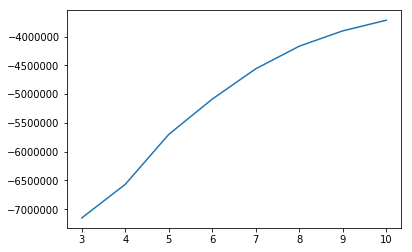

In [128]:
# Calculate with different number of centroids to see the loss-plot (elbow method)
n_cluster = range(3, 11)
kmeans = [KMeans(n_clusters=i).fit(data_PCA) for i in n_cluster]
scores = [kmeans[i].score(data_PCA) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [129]:
# 8 clusters (start at 3)
km = kmeans[5]

In [130]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [131]:
data_PCA['BookingCluster'] = km.predict(data_PCA)
#df['principal_feature1'] = data[0]
#df['principal_feature2'] = data[1]
#df['cluster'].value_counts()

In [132]:
data_PCA.head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster
row_id,,,,,,,,,,,
0,0.491802,0.719884,1.398681,0.677925,-0.272618,0.583344,-1.115041,0.663648,1.858719,-0.645262,4
1,0.102431,-1.514426,-0.756506,-1.094823,-0.797879,-0.073948,-0.107497,0.860155,-0.181617,1.271963,2
2,0.809931,1.544296,-0.713020,-0.506455,-0.656511,0.835293,0.325136,-0.988246,2.175869,-0.143698,2
3,-0.120843,0.320266,0.698902,-0.480831,-0.793651,-2.692508,0.593068,0.158248,-0.258116,0.775438,0
4,-0.803798,-0.821269,-1.044769,-0.647941,1.340156,0.084317,0.139098,0.168494,0.474288,0.108188,1


In [133]:
data_PCA.groupby(['BookingCluster']).size()

BookingCluster
0    110887
1    134416
2    243225
3    124599
4    134422
5     84531
6     57239
7      1068
dtype: int64

In [134]:
data_PCA['PricePerNight'] = PricePerNight

<Figure size 1080x576 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'4')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'2')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'0')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'1')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'7')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'3')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'6')

<Figure size 1080x576 with 0 Axes>

Text(0.5,0,'5')

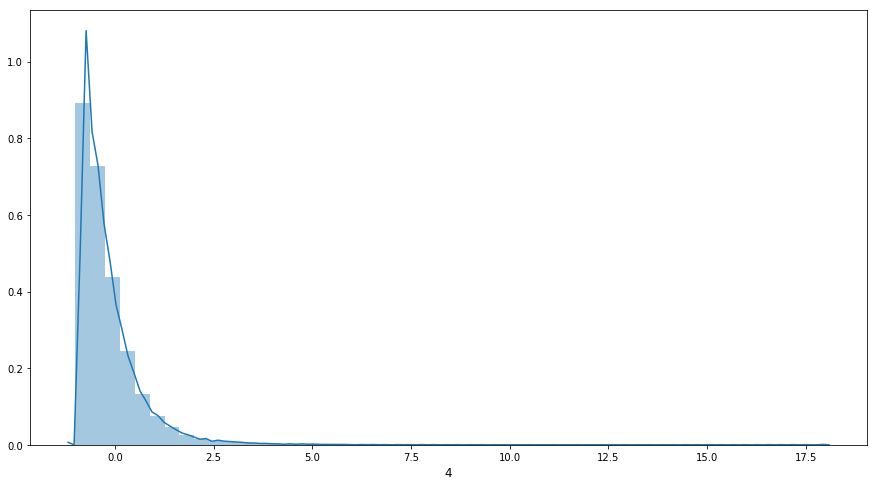

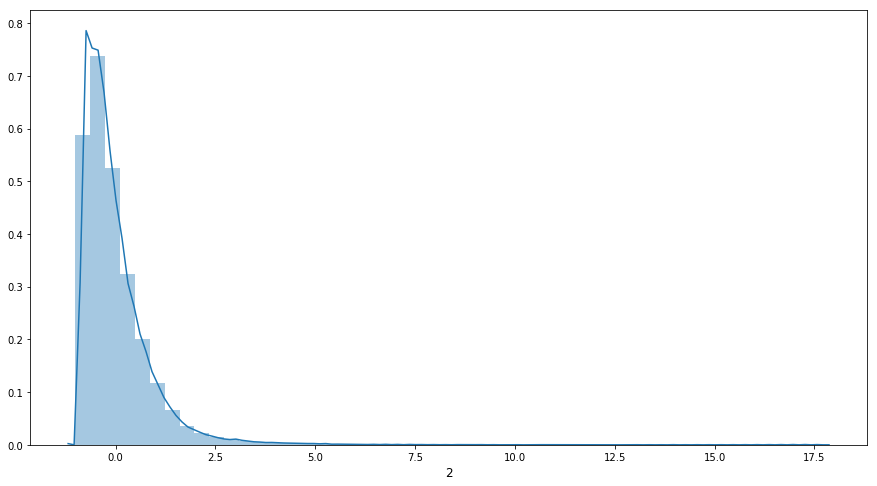

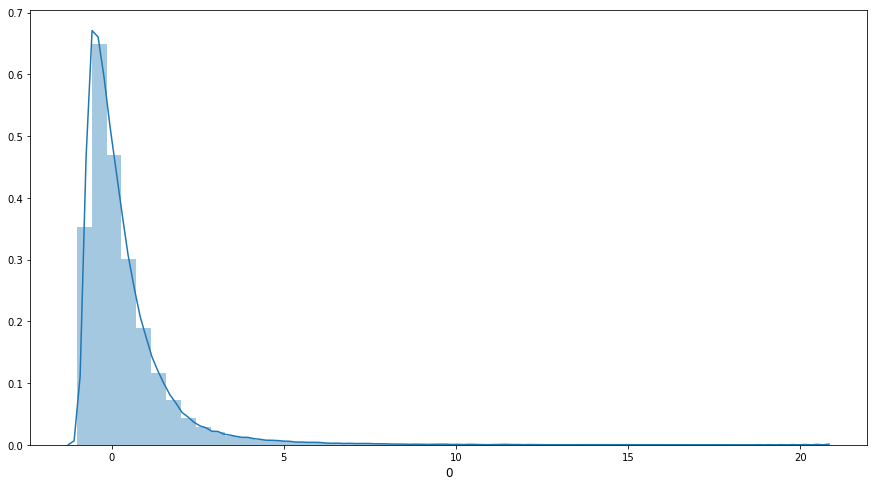

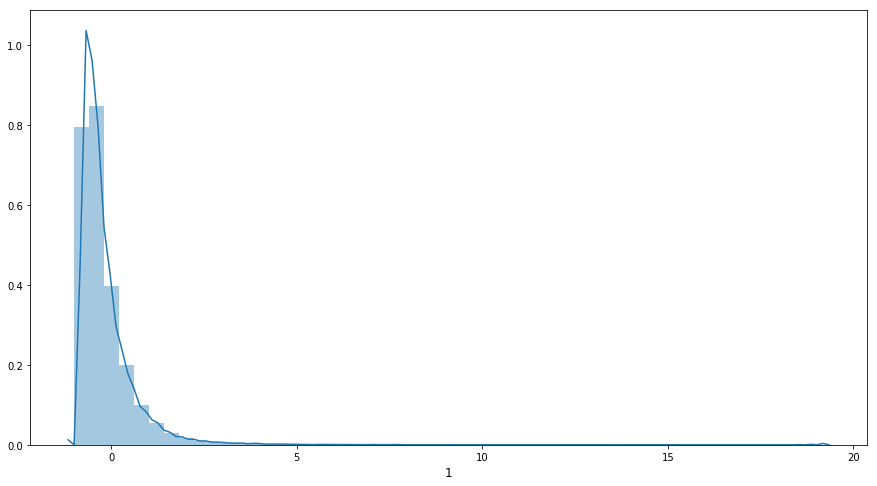

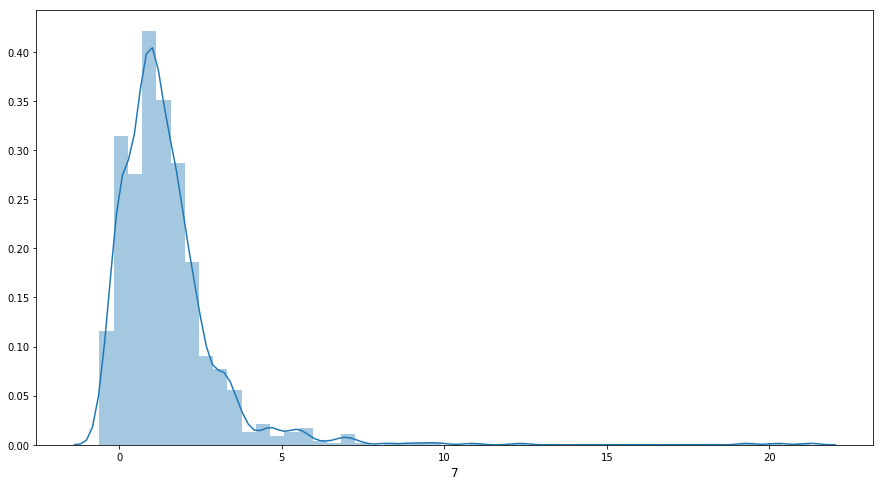

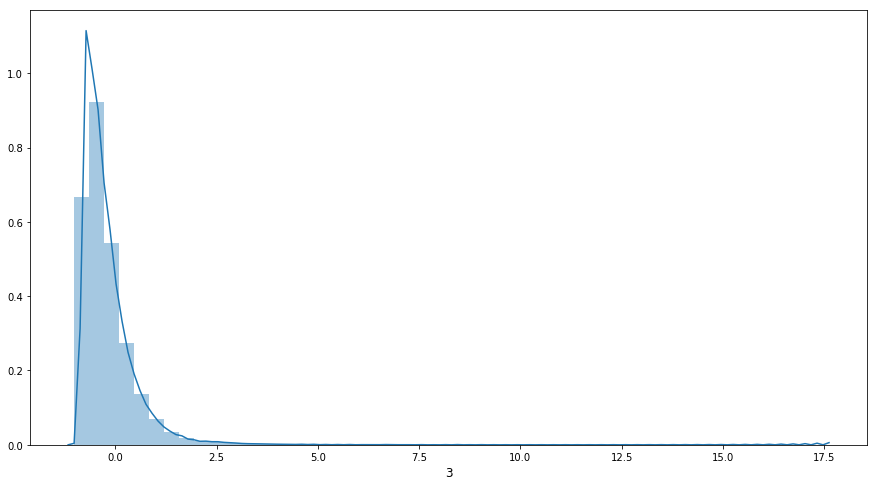

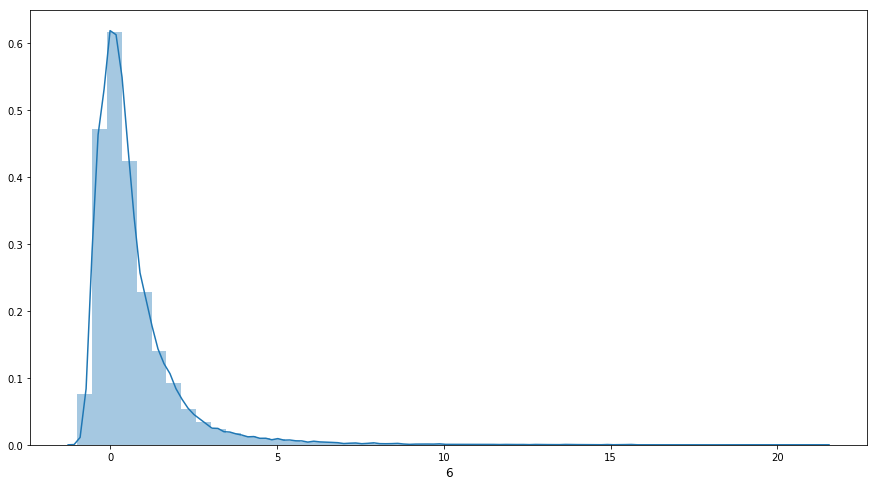

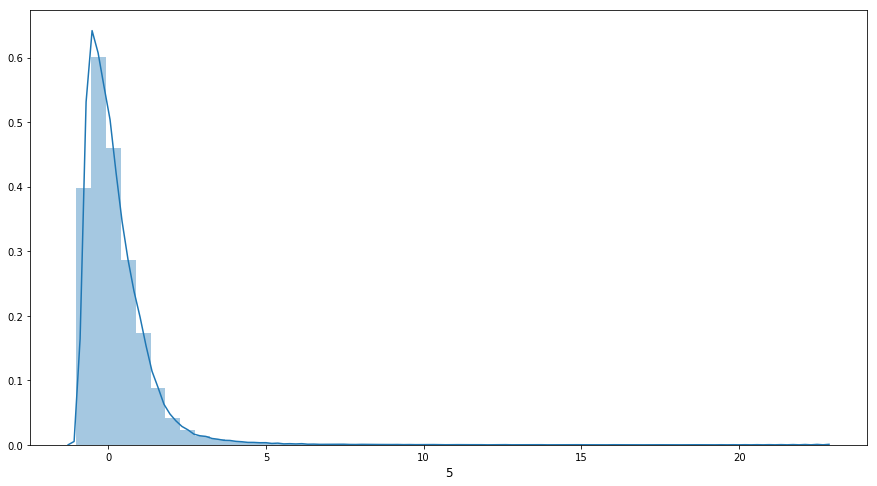

In [135]:
for i, cls in enumerate(data_PCA.BookingCluster.unique()):
    plt.figure(i,figsize=(15,8))
    sns.distplot(data_PCA.loc[(data_PCA.BookingCluster == cls),'PricePerNight'])
    plt.xlabel(cls, fontsize=12)

We can see similar distributions of prices in each. A fair assumption would be that clusters are dense around the centroids representing similar bookings. Outlier prices would be on the tails of the distribution. By running a regression line on the clusters for the prices, we can identify the outliers in each clusters. These would represent price points which do not make much sense as per the cluster centroids. 
##### (The logic is similar to that of Local Outlier Model, except that we are building statistical rules for an external variable - PricePerNight here)

##### Regression Modeling for each Cluster

In [136]:
df_cluster = [None] * 8

In [137]:
# Create new Data Frames for each of the 8 clusters
for i in range(0,8):
    df_cluster[i] = data_PCA.loc[data_PCA.BookingCluster == i,:]

We will now build regression models on each of the clusters. The outlier selection criteria will be based on 
1. Regression scores - R2 and RMSE, Kurtosis (high and low defines clusters better ie. easier to interpret outliers)
2. Price points and assumption 2(<1% anomalies) 

###### Cluster 0

In [138]:
df_cluster[0].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
3,-0.120843,0.320266,0.698902,-0.480831,-0.793651,-2.692508,0.593068,0.158248,-0.258116,0.775438,0,-0.311005
13,-0.541282,1.912193,0.312362,-1.502874,1.137739,-1.259864,-0.291787,0.215023,-0.748221,0.764548,0,0.902829
16,0.154908,0.712971,0.918635,-0.172873,-0.662135,-2.514066,0.396798,0.223817,-0.566545,-1.344434,0,-0.595665
34,-0.386500,1.244871,0.604743,-1.467527,-1.594774,-1.676427,0.252630,0.000521,0.462229,1.722879,0,-0.683391
39,-0.731307,2.540821,0.394972,-0.693751,0.968987,-1.310424,0.347077,-0.121198,0.363456,-0.146038,0,-0.255505


In [139]:
train = df_cluster[0].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[0].PricePerNight

In [140]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [141]:
metrics.r2_score(labels,pricePred)

0.23105814675563807

In [142]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

1.125099970789773

In [143]:
residuals = labels - pricePred
residuals.describe()

count    1.108870e+05
mean     4.357605e-15
std      1.125105e+00
min     -4.147135e+00
25%     -5.697534e-01
50%     -1.996243e-01
75%      2.240079e-01
max      1.956679e+01
Name: PricePerNight, dtype: float64

In [144]:
residuals.kurtosis()

31.588491268885033

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

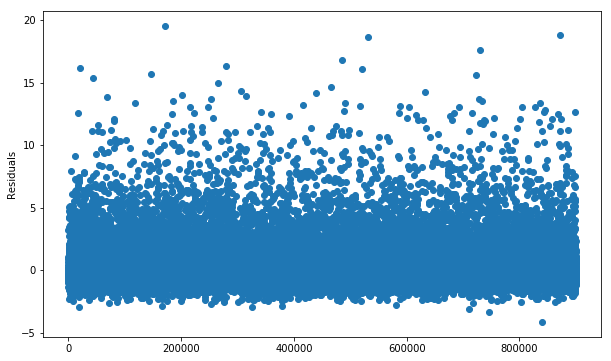

In [145]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

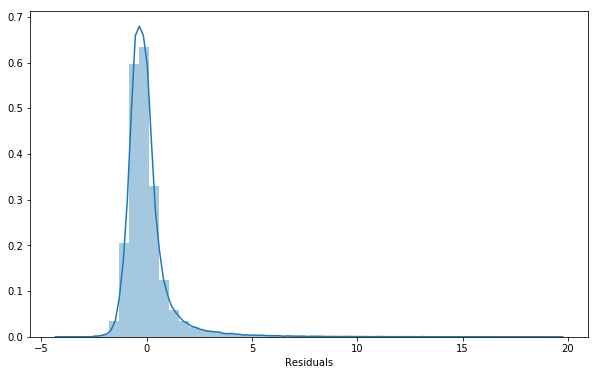

In [146]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [147]:
rightThreshold = 4.5
leftThreshold = -2.3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

1212
54


In [148]:
cluster_0_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_0_anomalies.columns=['Residuals']

In [149]:
print(cluster_0_anomalies.shape)
cluster_0_anomalies.head()

(1266, 1)


,Residuals
row_id,
982,-2.323727
1584,5.065809
1878,4.698069
3046,4.520205
3304,5.101379


###### Cluster 1

In [150]:
df_cluster[1].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
4,-0.803798,-0.821269,-1.044769,-0.647941,1.340156,0.084317,0.139098,0.168494,0.474288,0.108188,1,-0.475714
14,-0.060867,1.360653,-1.139386,1.823055,1.695543,-0.307617,-0.236322,-0.400568,-1.172504,-1.431208,1,0.752442
23,-1.117408,-0.137302,-1.146567,-0.046604,0.784860,0.109934,0.139802,-0.145213,0.561522,-0.171545,1,-0.379037
28,-0.991369,-0.233249,-1.115217,0.786555,1.175352,-0.378708,0.486478,-0.656682,0.751627,-0.694888,1,-0.214328
29,-1.099120,-0.058429,-1.089809,0.372944,0.782146,-0.210872,0.088490,-0.042475,0.142940,-1.402786,1,-0.625206


In [151]:
train = df_cluster[1].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[1].PricePerNight

In [152]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:
metrics.r2_score(labels,pricePred)

0.5635642032330768

In [154]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

0.5111609667019964

In [155]:
residuals = labels - pricePred
residuals.describe()

count    134416.000000
mean         -0.000483
std           0.511163
min          -3.429286
25%          -0.191779
50%          -0.046190
75%           0.089972
max          17.348618
Name: PricePerNight, dtype: float64

In [156]:
residuals.kurtosis()

90.4181297154641

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

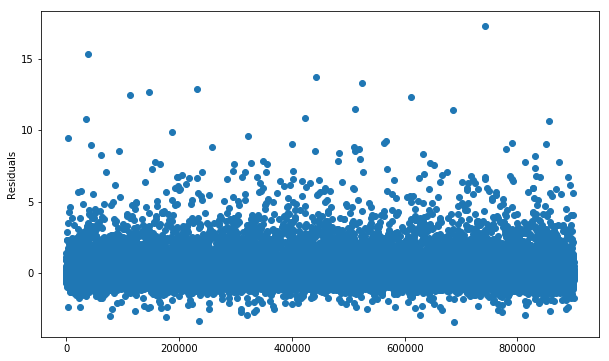

In [157]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

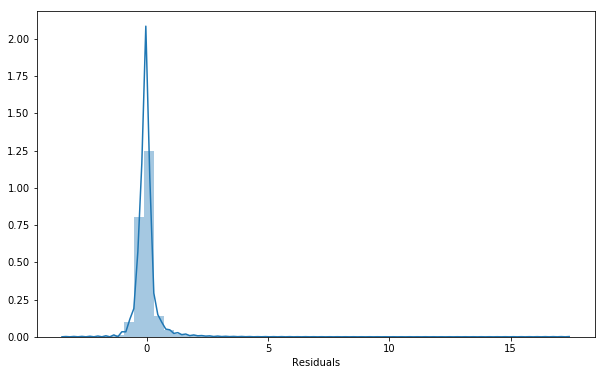

In [158]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [159]:
rightThreshold = 13
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

4
4


In [160]:
cluster_1_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_1_anomalies.columns=['Residuals']

In [161]:
print(cluster_1_anomalies.shape)
cluster_1_anomalies.head()

(8, 1)


,Residuals
row_id,
38270,15.328941
77284,-3.028881
176664,-3.084004
235107,-3.383481
443092,13.754016


###### Cluster 2

In [162]:
df_cluster[2].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
1,0.102431,-1.514426,-0.756506,-1.094823,-0.797879,-0.073948,-0.107497,0.860155,-0.181617,1.271963,2,-0.417529
2,0.809931,1.544296,-0.713020,-0.506455,-0.656511,0.835293,0.325136,-0.988246,2.175869,-0.143698,2,1.529439
6,-0.770826,-1.248106,-0.787024,0.661506,-1.601537,-0.835241,0.459480,-0.118245,0.544902,-0.237472,2,-0.963575
8,0.658304,-0.552942,-0.881549,0.168737,-0.386329,0.052303,-0.304722,0.195202,-0.942115,1.196515,2,-0.280570
10,-0.603094,-0.817615,-0.803325,-0.192828,-1.665584,-0.234068,0.280455,0.144392,0.804993,0.471399,2,-0.638633


In [163]:
train = df_cluster[2].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[2].PricePerNight

In [164]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [165]:
metrics.r2_score(labels,pricePred)

0.5804481563034873

In [166]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

0.5753489319622653

In [167]:
residuals = labels - pricePred
residuals.describe()

count    2.432250e+05
mean    -4.363442e-15
std      5.753501e-01
min     -5.015994e+00
25%     -2.275762e-01
50%     -5.803753e-02
75%      1.020997e-01
max      1.406739e+01
Name: PricePerNight, dtype: float64

In [168]:
residuals.kurtosis()

55.48110296484904

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

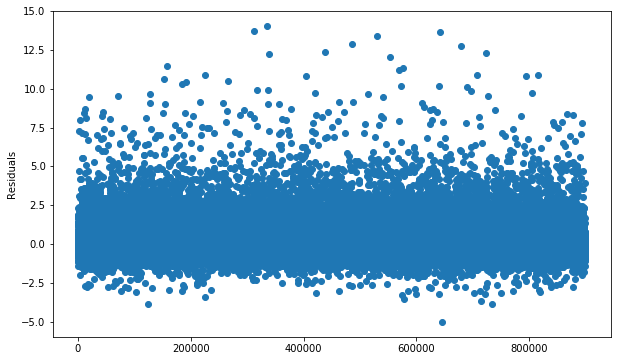

In [169]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

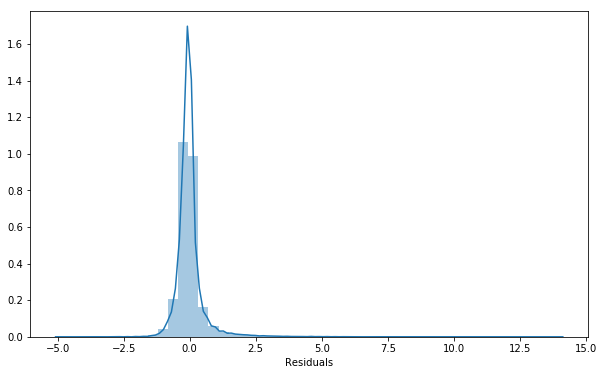

In [170]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [171]:
rightThreshold = 6
leftThreshold = -2.5
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

191
62


In [172]:
cluster_2_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_2_anomalies.columns=['Residuals']

In [173]:
print(cluster_2_anomalies.shape)
cluster_2_anomalies.head()

(253, 1)


,Residuals
row_id,
1750,7.277923
3707,7.971312
7051,7.118899
11288,8.446150
11720,8.709438


###### Cluster 3

In [174]:
df_cluster[3].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
11,0.885338,-0.861164,1.454716,-0.065178,0.468809,0.598523,1.669851,-1.719131,0.096689,0.631427,3,-0.089006
19,-0.443426,0.486459,1.012666,0.247929,-0.613574,1.087290,1.343694,-1.628620,0.016872,1.046210,3,1.510641
22,-0.086364,-0.257843,1.235888,-0.306241,-1.186123,1.068242,0.348941,-0.322618,-2.212650,-0.880510,3,-0.423795
33,0.030584,0.282022,1.303867,-0.019906,-0.785993,0.979631,1.310909,-1.425605,0.038638,-0.535418,3,0.275323
42,-0.563753,-0.573700,1.155971,-0.039444,-0.430967,0.633481,1.414436,-1.411585,-0.067645,0.269859,3,0.477629


In [175]:
train = df_cluster[3].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[3].PricePerNight

In [176]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [177]:
metrics.r2_score(labels,pricePred)

0.5553697186402835

In [178]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

0.4553491432301755

In [179]:
residuals = labels - pricePred
residuals.describe()

count    1.245990e+05
mean    -1.223771e-14
std      4.553510e-01
min     -3.877273e+00
25%     -1.795013e-01
50%     -4.010003e-02
75%      8.699357e-02
max      1.662129e+01
Name: PricePerNight, dtype: float64

In [180]:
residuals.kurtosis()

124.63973588747425

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

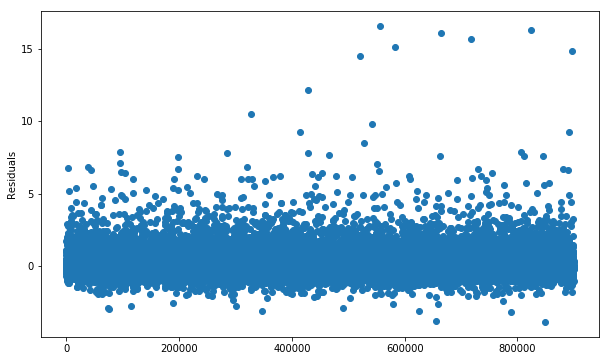

In [181]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

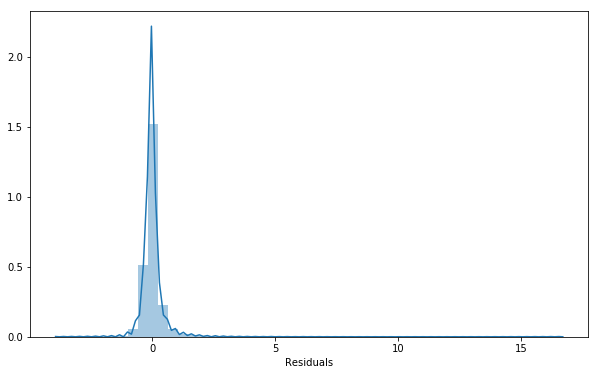

In [182]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [183]:
rightThreshold = 5.5
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

64
5


In [184]:
cluster_3_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_3_anomalies.columns=['Residuals']

In [185]:
print(cluster_3_anomalies.shape)
cluster_3_anomalies.head()

(69, 1)


,Residuals
row_id,
3799,6.784556
39214,6.822468
44580,6.648252
95132,7.872949
95610,7.129004


###### Cluster 4

In [186]:
df_cluster[4].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
0,0.491802,0.719884,1.398681,0.677925,-0.272618,0.583344,-1.115041,0.663648,1.858719,-0.645262,4,1.063062
5,-0.281828,-0.583922,1.293327,1.444807,-0.713776,-0.521177,-1.088150,0.842787,0.911271,-0.554056,4,-0.733520
7,-0.525723,-0.526617,1.138454,2.003150,-0.894053,-0.709499,-0.885984,0.341287,1.142187,0.256520,4,-0.450650
24,-1.275278,0.175428,0.923391,0.649672,1.066389,0.162262,-1.192539,0.826276,1.455882,-0.543449,4,-0.436327
27,-0.295123,-0.931202,1.190188,1.395487,-0.677449,-0.436205,-1.207994,0.912364,0.516893,0.417058,4,-0.211643


In [187]:
train = df_cluster[4].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[4].PricePerNight

In [188]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [189]:
metrics.r2_score(labels,pricePred)

0.5879275544224205

In [190]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

0.5255870744977578

In [191]:
residuals = labels - pricePred
residuals.describe()

count    1.344220e+05
mean    -1.307340e-15
std      5.255890e-01
min     -3.550839e+00
25%     -2.018427e-01
50%     -3.600236e-02
75%      8.954155e-02
max      1.577863e+01
Name: PricePerNight, dtype: float64

In [192]:
residuals.kurtosis()

79.32941164338489

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

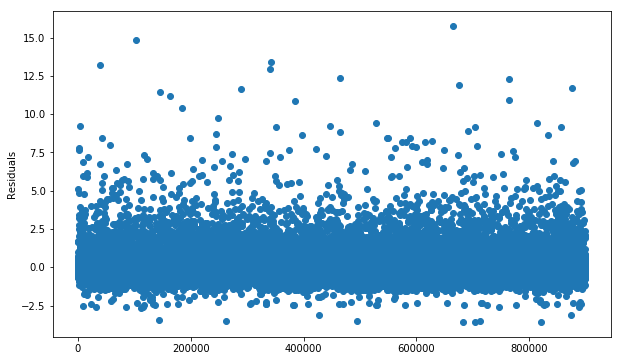

In [193]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

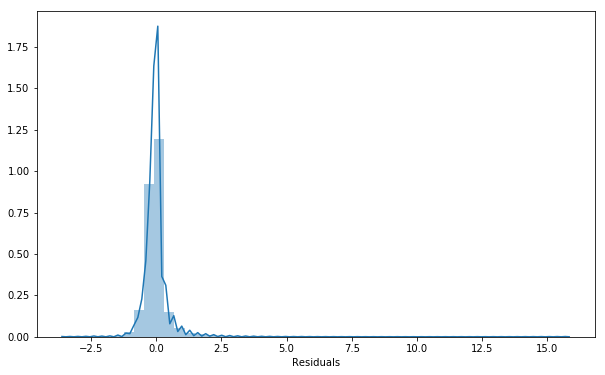

In [194]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [195]:
rightThreshold = 7
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

62
9


In [196]:
cluster_4_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_4_anomalies.columns=['Residuals']

In [197]:
print(cluster_4_anomalies.shape)
cluster_4_anomalies.head()

(71, 1)


,Residuals
row_id,
1330,7.773730
2066,7.671802
3224,9.205249
16987,7.198176
39182,13.179475


###### Cluster 5

In [198]:
df_cluster[5].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
17,1.621150,0.823495,-0.537740,-1.395274,0.196185,1.536017,0.441755,-0.736069,2.461206,1.655292,5,1.353988
49,2.157457,-0.249866,-0.260355,-0.043495,0.618301,0.102239,0.648952,-0.676011,1.329531,-0.581211,5,0.730959
55,2.049373,-1.176141,-0.224083,-0.153164,0.213365,-0.055357,0.557854,-0.176239,0.806015,-0.114241,5,-0.303844
60,4.531016,-0.578268,0.372706,-1.847432,1.955362,0.816678,0.728537,-0.848702,2.449858,-1.249851,5,0.866127
72,2.186871,-0.527482,-0.291883,-0.737021,1.419304,-0.081995,0.582280,-0.405083,1.229152,-1.005767,5,0.665612


In [199]:
train = df_cluster[5].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[5].PricePerNight

In [200]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [201]:
metrics.r2_score(labels,pricePred)

0.4921330419263015

In [202]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

0.7197366022072056

In [203]:
residuals = labels - pricePred
residuals.describe()

count    8.453100e+04
mean     1.066290e-16
std      7.197409e-01
min     -2.705032e+00
25%     -3.578128e-01
50%     -8.457519e-02
75%      2.167732e-01
max      1.851810e+01
Name: PricePerNight, dtype: float64

In [204]:
residuals.kurtosis()

46.414460210451686

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

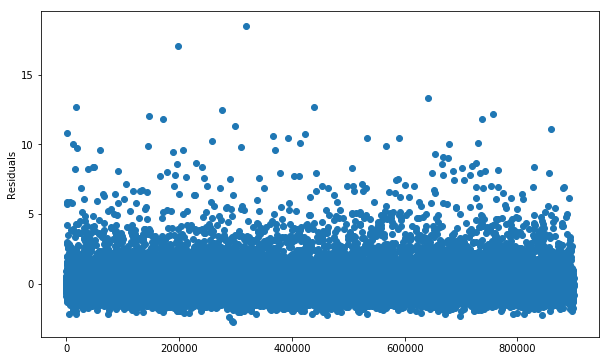

In [205]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

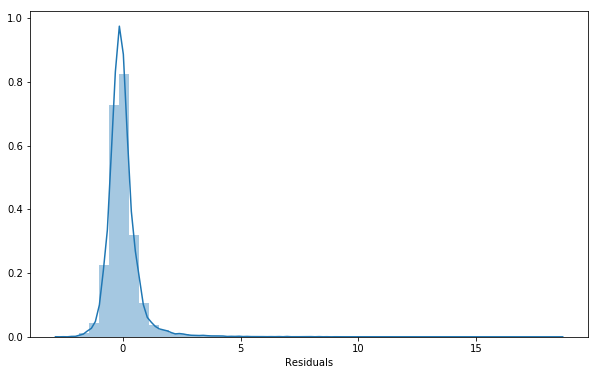

In [206]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [207]:
rightThreshold = 7
leftThreshold = -3.1
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

80
0


In [208]:
cluster_5_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_5_anomalies.columns=['Residuals']

In [209]:
print(cluster_5_anomalies.shape)
cluster_5_anomalies.head()

(80, 1)


,Residuals
row_id,
1412,10.821693
12240,10.042784
14714,8.277180
18052,12.715669
18232,9.732577


###### Cluster 6

In [210]:
df_cluster[6].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
12,0.239421,0.318150,0.946601,2.752024,-0.279056,-0.512872,-1.380290,0.413238,-0.403266,1.819607,6,-0.018289
85,1.965485,-0.758820,-0.734249,1.285493,0.431747,-0.321926,-0.098963,-0.480633,-1.469230,2.234557,6,-0.386198
88,2.220304,-0.508640,-0.579078,1.390719,0.257567,-0.496513,0.679491,-1.156935,0.314318,2.745623,6,0.243098
95,0.520793,-0.009562,-1.064918,1.671064,-0.262562,-0.535014,0.305065,-0.901194,-0.257146,2.736046,6,0.398855
122,-0.232116,0.550553,-1.437800,1.242679,1.478581,0.238150,-0.723050,0.180394,-2.307031,1.535542,6,-0.339650


In [211]:
train = df_cluster[6].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[6].PricePerNight

In [212]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [213]:
metrics.r2_score(labels,pricePred)

0.40726617410625965

In [214]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

1.0474258566005326

In [215]:
residuals = labels - pricePred
residuals.describe()

count    5.723900e+04
mean     2.040798e-16
std      1.047435e+00
min     -3.881801e+00
25%     -5.043147e-01
50%     -1.733268e-01
75%      1.866295e-01
max      1.811627e+01
Name: PricePerNight, dtype: float64

In [216]:
residuals.kurtosis()

32.11916740897004

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

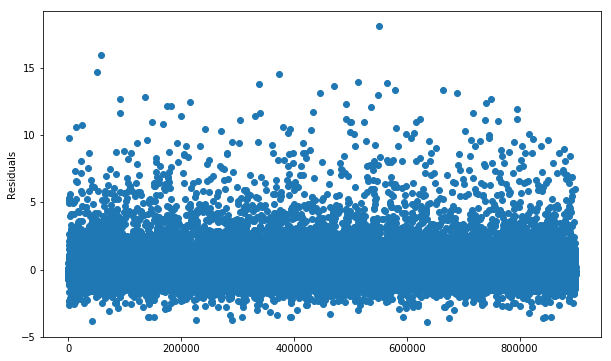

In [217]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

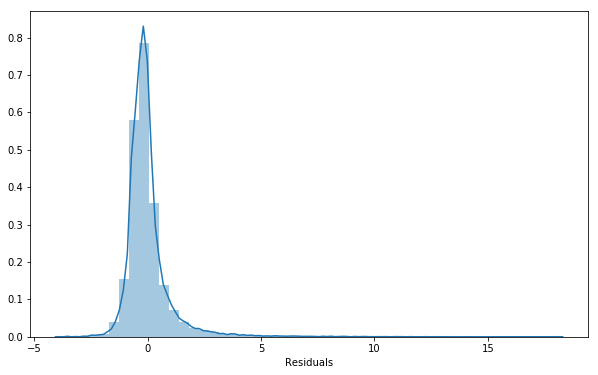

In [218]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [219]:
rightThreshold = 10
leftThreshold = -4
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

56
0


In [220]:
cluster_6_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_6_anomalies.columns=['Residuals']

In [221]:
print(cluster_6_anomalies.shape)
cluster_6_anomalies.head()

(56, 1)


,Residuals
row_id,
13613,10.550778
24124,10.708479
50854,14.704904
58774,15.925960
91851,12.678251


###### Cluster 7

In [222]:
df_cluster[7].head()

,0,1,2,3,4,5,6,7,8,9,BookingCluster,PricePerNight
row_id,,,,,,,,,,,,
9,1.529551,1.406031,1.016764,4.489786,1.357587,3.376046,19.086654,20.684761,0.223551,-0.215041,7,0.599370
178,2.449646,3.519129,1.222531,4.573398,1.783950,4.403025,19.101139,20.249463,1.126811,-2.164592,7,0.144630
530,2.205298,3.578324,1.189535,4.653728,1.523433,4.323304,19.211607,20.169210,1.393989,-2.008725,7,0.314710
2588,1.447766,3.229810,0.336832,6.432777,1.005129,3.756104,18.497588,20.052657,-1.476957,2.716943,7,1.074699
4691,2.709471,3.640180,0.432433,6.018348,1.711000,4.802024,17.764987,20.534580,-2.905107,2.792770,7,1.179433


In [223]:
train = df_cluster[7].drop(['PricePerNight','BookingCluster'], axis = 1)
labels = df_cluster[7].PricePerNight

In [224]:
regMod = linear_model.LinearRegression()
regMod.fit(train, labels)
pricePred = regMod.predict(train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [225]:
metrics.r2_score(labels,pricePred)

0.21706581729993057

In [226]:
metrics.mean_squared_error(labels,pricePred) ** (0.5)

1.5198570496864001

In [227]:
residuals = labels - pricePred
residuals.describe()

count    1.068000e+03
mean     8.915515e-13
std      1.520569e+00
min     -2.649960e+00
25%     -6.616652e-01
50%     -2.878938e-01
75%      2.283558e-01
max      1.718064e+01
Name: PricePerNight, dtype: float64

In [228]:
residuals.kurtosis()

48.09838619518506

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'Residuals')

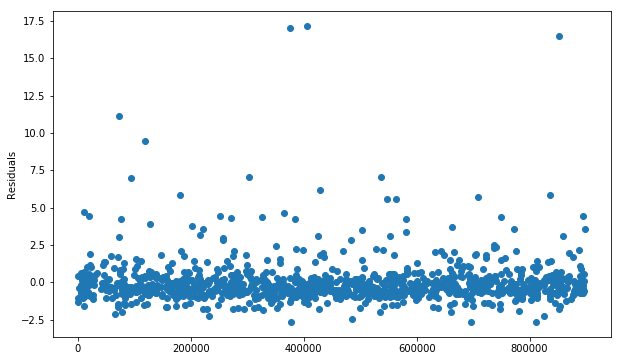

In [229]:
plt.figure(figsize=(10,6))
plt.scatter(residuals.index,residuals)
plt.ylabel('Residuals')

<Figure size 720x432 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Residuals')

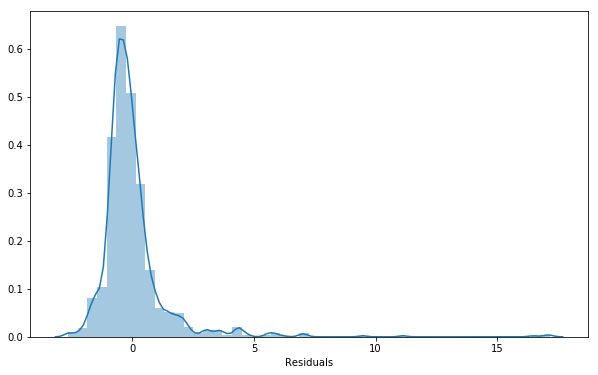

In [230]:
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.xlabel('Residuals')

In [231]:
rightThreshold = 8
leftThreshold = -3
print(residuals[residuals>rightThreshold].size)
print(residuals[residuals<leftThreshold].size)

5
0


In [232]:
cluster_7_anomalies = pd.DataFrame(residuals[(residuals>rightThreshold) | (residuals < leftThreshold)])
cluster_7_anomalies.columns=['Residuals']

In [233]:
print(cluster_7_anomalies.shape)
cluster_7_anomalies.head()

(5, 1)


,Residuals
row_id,
71907,11.129459
118797,9.488542
375539,17.014014
405031,17.180638
851573,16.480380


In [234]:
df_anomalyPred = cluster_0_anomalies.append([
                                             cluster_1_anomalies,
                                             cluster_2_anomalies,
                                             cluster_3_anomalies,
                                             cluster_4_anomalies,
                                             cluster_5_anomalies,
                                             cluster_6_anomalies,
                                             cluster_7_anomalies,
                                             ]) 

In [235]:
df_anomalyPred.head()

,Residuals
row_id,
982,-2.323727
1584,5.065809
1878,4.698069
3046,4.520205
3304,5.101379


In [236]:
df_anomalyPred.shape

(1808, 1)

<img src="Summary1.png" alt="Drawing" style="width: 600px;"/>

### Anomaly Labeling and Submission <a name="submit"></a>

In [237]:
# Return a description of the anomalies
print(df_anomaly1.index)
print(df_anomaly1.index.shape)
print(df_anomaly1.index.unique().size)

Int64Index([  1013,   1046,   1965,   2273,   2292,   2490,   2516,   2583,
              2771,   3100,
            ...
            899414, 899415, 899417, 899433, 899438, 899452, 899461, 899469,
            899470, 899474],
           dtype='int64', length=8820)
(8820,)
8820


In [238]:
print(df_anomaly2.index)
print(df_anomaly2.index.shape)
print(df_anomaly2.index.unique().size)

Int64Index([ 23073,  23537,  27815,  32092,  44680,  49265,  57407,  70675,
             73282,  87454,
            ...
            848874, 851662, 855805, 859394, 880888, 883813, 887007, 892812,
            894950, 897293],
           dtype='int64', length=112)
(112,)
112


In [239]:
print(df_anomaly3.index)
print(df_anomaly3.index.shape)
print(df_anomaly3.index.unique().size)

Int64Index([   717,  14578,  22116,  23731,  31557,  33996,  49117,  65252,
             80070,  81760,
            ...
            842411, 842988, 852212, 869319, 870548, 878919, 883726, 884331,
            890846, 891518],
           dtype='int64', name='row_id', length=123)
(123,)
123


In [240]:
print(df_anomalyPred.index)
print(df_anomalyPred.index.shape)
print(df_anomalyPred.index.unique().size)

Int64Index([   982,   1584,   1878,   3046,   3304,   5172,   6712,   7288,
              7974,   8543,
            ...
            750302, 762137, 795630, 795988, 817409,  71907, 118797, 375539,
            405031, 851573],
           dtype='int64', name='row_id', length=1808)
(1808,)
1808


In [241]:
df_anomaly3.index.isin(df_anomalyPred.index).sum()

0

In [242]:
# Aggregation of all the anomalies indexes
anomalyIndex = df_anomaly1.index.append([df_anomaly2.index,df_anomaly3.index,df_anomalyPred.index]) 

In [243]:
anomalyIndex.unique().size

10863

In [244]:
anomalyIndex.shape

(10863,)

In [245]:
# Creating the variable 'anomaly' for final submission
finalPrediction =  pd.read_csv('DATATHON_STU_NEW.csv', index_col= 0)
finalPrediction = pd.DataFrame(finalPrediction.loc[:,'row_id'])
finalPrediction['anomaly'] = 0

In [246]:
finalPrediction.shape

(899477, 2)

In [247]:
finalPrediction.loc[finalPrediction.row_id.isin(anomalyIndex),'anomaly'] = 1

In [248]:
print("TOTAL ANOMALIES IDENTIFIED:")
print(finalPrediction.anomaly.sum())

print("TOTAL ANOMALIES Percentage:")
print(round(((finalPrediction.anomaly.sum()/finalPrediction.shape[0])*100),2),"%")


TOTAL ANOMALIES IDENTIFIED:
10863
TOTAL ANOMALIES Percentage:
1.21 %


In [249]:
# Saving the final submission dataset
finalPrediction.to_csv('TeamC_FinalPrediction.csv', sep=',', header=True)

---------------------------------------------------END OF DOCUMENT--------------------------------------------------